# Cell segmentation and quantification  
We will use here cellpose for cell segmentation:

Stringer, C., Wang, T., Michaelos, M., & Pachitariu, M. (2021). Cellpose: a 
generalist algorithm for cellular segmentation. Nature methods, 18(1), 100-106. 

To install cellpose, type in a terminal with the environment activated:


In [1]:
#!pip install cellpose

In [2]:
# Run this cell is your are developing the code locally
%load_ext autoreload
%autoreload 2
import sys
import site
site.addsitedir('../') 

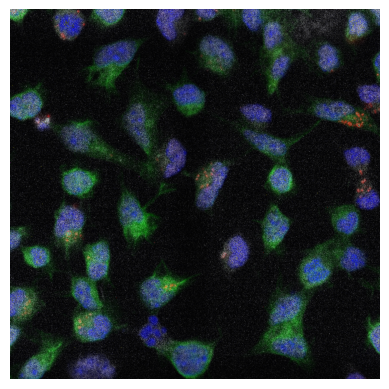

In [3]:
import matplotlib.pyplot as plt
from mug import utils
import tifffile

# load the image
img = tifffile.imread('../data/cells.tif')

# associate channels and indices
channels = {'nuclei':3,'cells':1,'label1':0,'label2':2}

# display the image, indicating the color maps for each channel
utils.imshow(img, ['red','green','gray','blue'], [50,99.99])

We start by checking the channel order from the original image as it is 
decoded by cellpose.

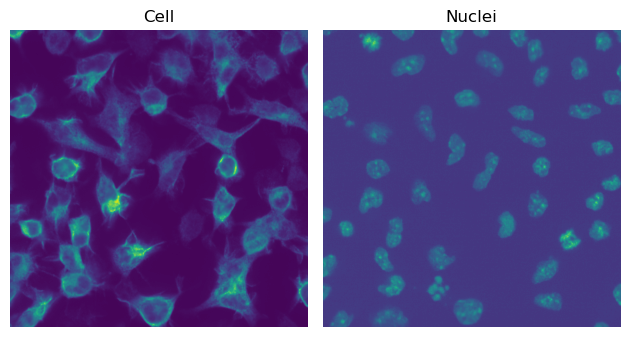

In [4]:
from cellpose import transforms
tmp = transforms.reshape(img, [channels['cells']+1, channels['nuclei']+1])
tmp.shape
fig, ax = plt.subplots(1,2)
ax[0].imshow(tmp[:,:,0])
ax[0].set_title('Cell')
ax[0].axis('off')
ax[1].imshow(tmp[:,:,1])
ax[1].set_title('Nuclei')
ax[1].axis('off')
fig.tight_layout()

Segment cells using the nuclear marker and the cell marker. 
To improve the results, tune the following parameters
- diameter (default 60) is the scale of the objects in pixels
- flow_threshold (default 0.4) is a threshold on the flows image
- cellprob_threshold help discarding less likely objects
- min_size allows to remove smaller regions

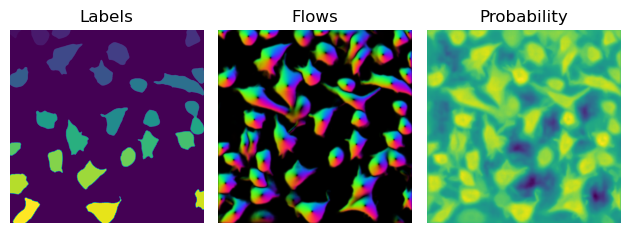

In [27]:
from cellpose import models, core # cell segmentation
model = models.Cellpose(gpu=core.use_gpu(), model_type='cyto2')

mask, flows, styles, diams = model.eval(
    img,
    channel_axis = 0, 
    channels = [channels['cells']+1, channels['nuclei']+1],
    diameter = 100, 
    flow_threshold = 0.1, 
    cellprob_threshold = 0.25, # default is 0
    min_size = 2000 # filter out smaller cells
    )
fig, ax = plt.subplots(1,3)
ax[0].imshow(mask)
ax[0].axis('off')
ax[0].set_title('Labels')
ax[1].imshow(flows[0])
ax[1].axis('off')
ax[1].set_title('Flows')
ax[2].imshow(flows[2])
ax[2].axis('off')
ax[2].set_title('Probability')
fig.tight_layout()


We can represent the segmentation using regionprops and find_contours

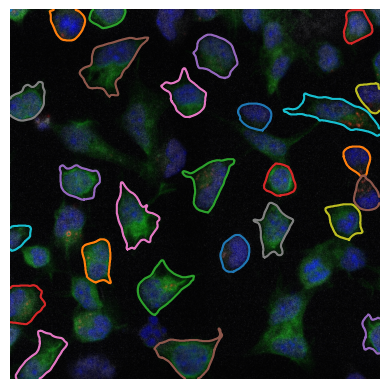

In [28]:
from skimage.measure import regionprops, find_contours
from skimage import morphology

# preprocess the image with labels
signal = morphology.white_tophat(img[channels['label1']], morphology.disk(10))

# measure in regions defined by the mask
props = regionprops(mask, signal)

# display segmentation as outlines
utils.imshow(img,['red','green','gray','blue'],saturation=[50,100])
for p in props:
    c = find_contours(mask==p.label,0.5)
    plt.plot(c[0][:,1],c[0][:,0])
plt.axis('off');

Let's now extract some relevant measurements from the regionsprops list:

In [29]:
import pandas as pd
tbl = pd.DataFrame({
    'Area [px]': [m.area for m in props],
    'Mean Intenisty': [m.intensity_mean for m in props]
})
tbl.head()

,Area [px],Mean Intenisty
0,1866,76.448553
1,6540,79.270031
2,3970,26.291940
3,5341,42.429320
4,9966,28.025286


Finally, we can look at the distribution of the values extracted for each cell.

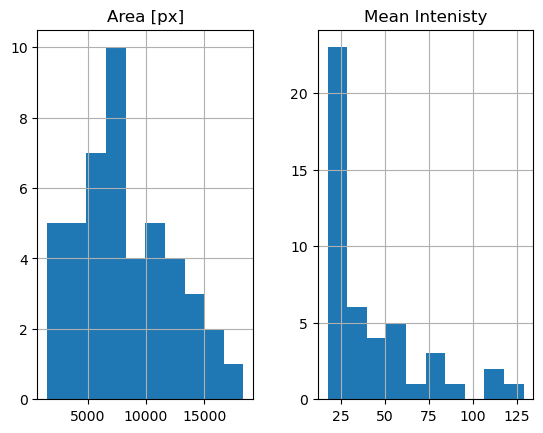

In [8]:
tbl.hist();